Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import libraries

In [ ]:
import os
import numpy as np
import pandas as pd
from glob import glob
import random,shutil
from keras.applications import MobileNet
from keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator as idg, img_to_array
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from skimage import data, img_as_float
from skimage import exposure
from skimage.io import imread
import matplotlib
import tensorflow as tf
#from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline

Link to path and output number of images in each folder

In [ ]:
data_path = r'/content/drive/MyDrive/Lungs_CT_Covid19_Detect/original_data_set'
positive_cases_path = (r'/content/drive/MyDrive/Lungs_CT_Covid19_Detect/original_data_set/CT_COVID')
negative_cases_path = (r'/content/drive/MyDrive/Lungs_CT_Covid19_Detect/original_data_set/CT_NonCOVID')

#File paths
positive_images_path = glob(os.path.join(positive_cases_path,"*.png"))
negative_images_path = glob(os.path.join(negative_cases_path,"*.png"))
negative_images_path.extend(glob(os.path.join(negative_cases_path,"*.jpg")))

covid = {'class': 'CT_COVID', 'path': positive_cases_path, 'images': positive_images_path}
non_covid = {'class': 'CT_NonCOVID', 'path': negative_cases_path, 'images': negative_images_path}

total_positive_covid_images = len(positive_images_path)
total_negative_covid_images = len(negative_images_path)
print("Number of Positive Covid-19 images: {}".format(total_positive_covid_images))
print("Number of Negative Covid-19 images: {}".format(total_negative_covid_images))

Number of Positive Covid-19 images: 349
Number of Negative Covid-19 images: 397


Display a Positive Image and a Negative Image

Image POS Shape (541, 720, 4)
Image NEG Shape (384, 512, 3)


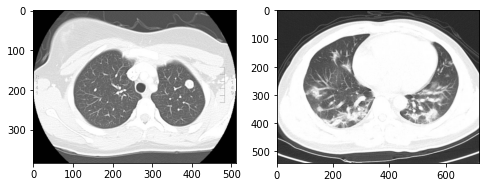

In [ ]:
positive_image = plt.imread(positive_images_path[30])
negative_image = plt.imread(negative_images_path[25])

f = plt.figure(figsize=(8, 8))
f.add_subplot(1, 2, 1)
plt.imshow(negative_image)
f.add_subplot(1,2, 2)
plt.imshow(positive_image)

print("Image POS Shape {}".format(positive_image.shape))
print("Image NEG Shape {}".format(negative_image.shape))

In [ ]:
positive_image1 = plt.imread(positive_images_path[30])
positive_image2 = plt.imread(positive_images_path[31])
positive_image3 = plt.imread(positive_images_path[33])
positive_image4 = plt.imread(positive_images_path[35])
positive_image5 = plt.imread(positive_images_path[1])

negative_image1 = plt.imread(negative_images_path[3])
negative_image2 = plt.imread(negative_images_path[15])
negative_image3 = plt.imread(negative_images_path[25])
negative_image4 = plt.imread(negative_images_path[70])
negative_image5 = plt.imread(negative_images_path[110])

5 Covid Positive sample images

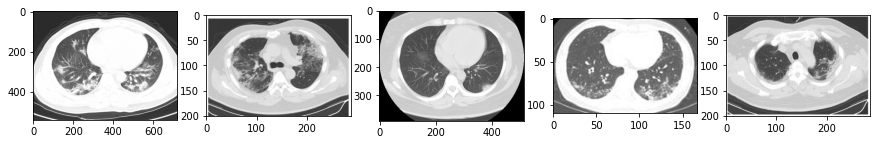

In [ ]:
f = plt.figure(figsize=(15, 15))
f.add_subplot(1, 5, 1)
plt.imshow(positive_image1)
f.add_subplot(1, 5, 2)
plt.imshow(positive_image2)
f.add_subplot(1, 5, 3)
plt.imshow(positive_image3)
f.add_subplot(1, 5, 4)
plt.imshow(positive_image4)
f.add_subplot(1, 5, 5)
plt.imshow(positive_image5)

5 Covid Negative sample images

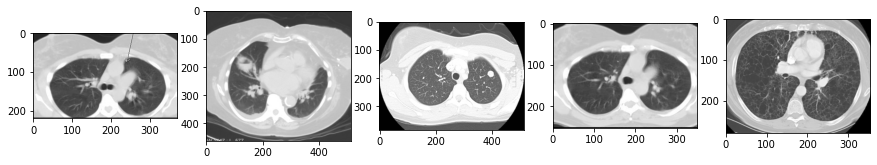

In [ ]:
f = plt.figure(figsize=(15, 15))
f.add_subplot(1, 5, 1)
plt.imshow(negative_image1)
f.add_subplot(1, 5, 2)
plt.imshow(negative_image2)
f.add_subplot(1, 5, 3)
plt.imshow(negative_image3)
f.add_subplot(1, 5, 4)
plt.imshow(negative_image4)
f.add_subplot(1, 5, 5)
plt.imshow(negative_image5)

## Image Transformation

Reference: https://scikit-image.org/docs/0.13.x/auto_examples/color_exposure/plot_equalize.html

In [ ]:
def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    img = img_as_float(img)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    #Image Display
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    #Histogram Display
    ax_hist.hist(img.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    #Cumulative Distribution Display
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


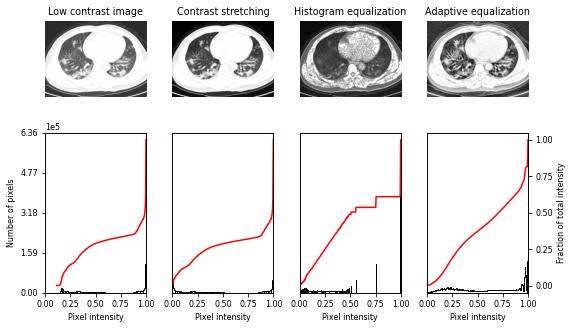

In [ ]:
#Load image
img = positive_image

#Set font size for images
matplotlib.rcParams['font.size'] = 8

#Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

#Histogram Equalization
img_eq = exposure.equalize_hist(img)

#Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

#Display results
fig = plt.figure(figsize=(8, 5)) 
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

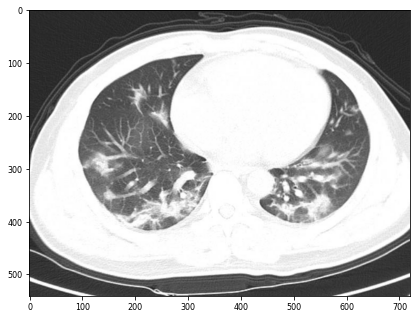

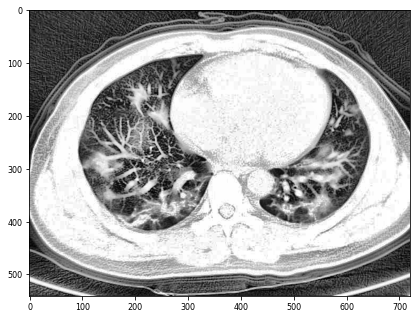

In [ ]:
#Original Image
f = plt.figure(figsize=(15, 15))
f.add_subplot(1, 2, 1)
plt.imshow(positive_image)
#Adaptive Histogram Equalized Image
e = plt.figure(figsize=(15, 15))
e.add_subplot(1, 2, 1)
plt.imshow(img_adapteq)

In [ ]:
# Applies Adaptive Histogram Equalization to all the images in our dataset.
#   *** ONLY NEED TO RUN IT ONCE ***
#  for categories in [covid,non_covid]:
#      for images in categories['images']:
#        img=imread(images)
#        img=exposure.equalize_adapthist(img, clip_limit=0.03)
#        plt.imsave(images,img)
#        print(images)

Moving images at random to Train and Test folder covid and non_covid folders we will have 80-20 split

In [ ]:
random.seed(258)

In [ ]:
for files in random.sample(covid['images'], int (0.2*len(covid['images']))):
        shutil.copy2(files, '/content/drive/MyDrive/Lungs_CT_Covid19_Detect/sanity_testing/test/' + covid['class'])

In [ ]:
for files in random.sample(non_covid['images'], int (0.2*len(non_covid['images']))):
        shutil.copy2(files, '/content/drive/MyDrive/Lungs_CT_Covid19_Detect/sanity_testing/test/' + non_covid['class'])

In [ ]:
for files in random.sample(covid['images'], int (0.4*len(covid['images']))):
        shutil.copy2(files, '/content/drive/MyDrive/Lungs_CT_Covid19_Detect/sanity_testing/train/' + covid['class'])

In [ ]:
for files in random.sample(non_covid['images'], int (0.4*len(non_covid['images']))):
        shutil.copy2(files, '/content/drive/MyDrive/Lungs_CT_Covid19_Detect/sanity_testing/train/' + non_covid['class'])

In [ ]:
print(len(os.listdir('/content/drive/MyDrive/Lungs_CT_Covid19_Detect/sanity_testing/train/CT_COVID')))
print(len(os.listdir('/content/drive/MyDrive/Lungs_CT_Covid19_Detect/sanity_testing/test/CT_COVID')))
print(len(os.listdir('/content/drive/MyDrive/Lungs_CT_Covid19_Detect/sanity_testing/train/CT_NonCOVID')))
print(len(os.listdir('/content/drive/MyDrive/Lungs_CT_Covid19_Detect/sanity_testing/test/CT_NonCOVID')))

139
69
158
79


Following augmentation to be performed on the images: translation (± 10% in x and y directions), rotation (± 10◦), horizontal fip, zoom (± 15%), and intensity shift (± 10%).

In [ ]:
datagen = idg(
    rescale=1./255,
    brightness_range = [.1,.2],
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.15
    )

In [ ]:
train_generated = datagen.flow_from_directory(batch_size=32,
                                                           directory='/content/drive/MyDrive/Lungs_CT_Covid19_Detect/sanity_testing/train/',
                                                           shuffle=True,
                                                           target_size=(224, 224),
                                                           class_mode='categorical')

Found 297 images belonging to 2 classes.


In [ ]:
test_generated = datagen.flow_from_directory(batch_size=32,
                                                           directory='/content/drive/MyDrive/Lungs_CT_Covid19_Detect/sanity_testing/test/',
                                                           target_size=(224, 224),
                                                           class_mode='categorical')

Found 148 images belonging to 2 classes.


We can use train_generated and test_generated for model training from now on.


## Sanity Testing

Experimenting with different preTrained cnn models

# VGG16

In [ ]:
base_model = VGG16(input_shape = (224, 224, 3), 
include_top = False, 
weights = 'imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
history = model.fit(train_generated,validation_data=test_generated,steps_per_epoch=10,epochs=10)

Epoch 1/10
10/10 [==============================] - 12s 1s/step - loss: 4.0396 - accuracy: 0.5000 - val_loss: 0.7383 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 8s 857ms/step - loss: 1.0539 - accuracy: 0.5000 - val_loss: 0.7432 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 8s 838ms/step - loss: 0.7537 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 8s 837ms/step - loss: 0.6955 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 8s 838ms/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - 8s 889ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
10/10 [==============================] - 8s 833ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/

# MobileNet

In [ ]:
model1 = MobileNet()
print(model1.summary())

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________

In [ ]:
base_model1=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model1.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
modelMobile = tf.keras.models.Model(base_model1.input, outputs=preds)

In [ ]:
modelMobile.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

mobile_net = modelMobile.fit(train_generated, steps_per_epoch = 10, epochs = 10)

Epoch 1/10
10/10 [==============================] - 61s 5s/step - loss: 1.2226 - accuracy: 0.5558
Epoch 2/10
10/10 [==============================] - 6s 546ms/step - loss: 0.4080 - accuracy: 0.8255
Epoch 3/10
10/10 [==============================] - 6s 562ms/step - loss: 0.3447 - accuracy: 0.8356
Epoch 4/10
10/10 [==============================] - 6s 558ms/step - loss: 0.2928 - accuracy: 0.8910
Epoch 5/10
10/10 [==============================] - 6s 556ms/step - loss: 0.2264 - accuracy: 0.9314
Epoch 6/10
10/10 [==============================] - 6s 545ms/step - loss: 0.2315 - accuracy: 0.9204
Epoch 7/10
10/10 [==============================] - 6s 559ms/step - loss: 0.1478 - accuracy: 0.9465
Epoch 8/10
10/10 [==============================] - 6s 550ms/step - loss: 0.1770 - accuracy: 0.9252
Epoch 9/10
10/10 [==============================] - 6s 614ms/step - loss: 0.1710 - accuracy: 0.9498
Epoch 10/10
10/10 [==============================] - 6s 561ms/step - loss: 0.1317 - accuracy: 0.9446


# ResNet

In [ ]:
model2 = ResNet50()
print(model2.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
base_model2 = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

In [ ]:
for layer in base_model2.layers:
    layer.trainable = False

In [ ]:
base_model2 = Sequential()
base_model2.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model2.add(Dense(1, activation='sigmoid'))

In [ ]:
base_model2.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
resnet = base_model2.fit(train_generated, validation_data = test_generated, steps_per_epoch = 10, epochs = 10)

Epoch 1/10
10/10 [==============================] - 14s 1s/step - loss: 2.5830 - accuracy: 0.5000 - val_loss: 0.7983 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 9s 908ms/step - loss: 2.1105 - accuracy: 0.5000 - val_loss: 0.7931 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 9s 914ms/step - loss: 2.0042 - accuracy: 0.5000 - val_loss: 0.6958 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 9s 899ms/step - loss: 1.8721 - accuracy: 0.5000 - val_loss: 0.8021 - val_accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 9s 896ms/step - loss: 1.8791 - accuracy: 0.5000 - val_loss: 0.7514 - val_accuracy: 0.5000
Epoch 6/10
10/10 [==============================] - 9s 963ms/step - loss: 1.9862 - accuracy: 0.5000 - val_loss: 0.7061 - val_accuracy: 0.5000
Epoch 7/10
10/10 [==============================] - 9s 902ms/step - loss: 1.7104 - accuracy: 0.5000 - val_loss: 0.8751 - val_accuracy: 0.5000
Epoch 8/